# Import necessary packages and libraries

In [1]:
import sys

# The current environment is automatically detected
# and set to either "GOOGLE_COLAB" or "LOCAL"
# depending on where the script is being run.

CURRENT_ENVIRONMENT = "GOOGLE_COLAB" if "google.colab" in sys.modules else "LOCAL"


In [2]:
import os
import shutil

if CURRENT_ENVIRONMENT == "GOOGLE_COLAB":
    from google.colab import drive

    # Mount Google Drive
    drive.mount('/content/drive', force_remount=True)

    # If the utils directory exists, delete it
    if os.path.exists('/content/utils'):
        shutil.rmtree('/content/utils')

    # Copy the utils.zip file to the current directory
    !cp /content/drive/MyDrive/utils.zip /content/utils.zip

    # Unzip the utils.zip file
    !unzip -q /content/utils.zip -d /content/utils

    # Delete the utils.zip file
    !rm /content/utils.zip

In [3]:
# Set to True if you want to skip all EDA
# and data preprocessing steps, otherwise set to False.
SKIP_TO_TRAINING = False

In [4]:
if CURRENT_ENVIRONMENT == "LOCAL":
    from utils.constants import *
elif CURRENT_ENVIRONMENT == "GOOGLE_COLAB":
    from utils.constants_colab import *
elif CURRENT_ENVIRONMENT == "KAGGLE":
    from utils.constants_kaggle import *

In [5]:
import os
from utils.zipper import read_file, write_file

install_file = os.path.join(DATA_DIR, "install.txt")

# Create the directory if it does not exist
os.makedirs(DATA_DIR, exist_ok=True)

install_content = read_file(install_file)

if ENVIRONMENT == "LOCAL":
    requirements_file = "requirements.txt"
    requirements_content = read_file(requirements_file)
    if install_content != requirements_content:
        get_ipython().system("pip install -r requirements.txt")
        write_file(install_file, requirements_content)
elif ENVIRONMENT == "GOOGLE_COLAB" and not SKIP_TO_TRAINING:
    if install_content != "imagehash":
        get_ipython().system("pip install imagehash")
        write_file(install_file, "imagehash")

In [6]:
if ENVIRONMENT == "LOCAL":
    from utils.cache import reload_custom_libraries

    # Refresh library cache
    reload_custom_libraries()

In [7]:
if ENVIRONMENT == "LOCAL":
    from utils.zipper import zip_dir

    # Zip the reloaded libraries to be used in Google Colab
    zip_dir(UTILS_DIR, f"{ZIPPED_RESOURCES_DIR}/utils.zip")

In [8]:
from utils.zipper import unzip_file

if ENVIRONMENT != "LOCAL" or (ENVIRONMENT == "LOCAL"):
    # Check if the zipped preprocessed datasets file exists and ROOT_DATASET_DIR does not exist
    if os.path.exists(PREPROCESSED_DATASETS_ZIP):
        print("Cached preprocessed datasets found.")
        if not os.path.exists(ROOT_DATASET_DIR):
            print("Extracting preprocessed datasets...")
            unzip_file(
                PREPROCESSED_DATASETS_ZIP,
                PREPROCESSED_DATASETS_EXTRACT_DIR,
            )
            print("Preprocessed datasets extracted.")
        else:
            print("Directory with preprocessed datasets found. Skipping extraction...")
    else:
        print("Cached preprocessed datasets not found. Skipping extraction...")

Cached preprocessed datasets not found. Skipping extraction...


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from PIL import ImageFile
import os, sys
from tqdm.notebook import tqdm
from utils.image_process import (
        get_category_styles,
        process_images,
        get_category_image_paths,
        resize_images,
        get_majority_class,
        identify_minority_classes,
        calculate_category_oversampling,
        calculate_style_oversampling,
        oversample_minority_classes,
    )
import sys
sys.path.append("../FURNITURE-CLASSIFIER")



# Introduction

## Problem Statement
The assignment requires us to handle an image classification project, in which we will have to build 3 models to solve the task of furniture classification. With the dataset has been provided, we will need to finish the following task

Task 1: Classify furniture item by their categories

Task 2: Classify the furniture item and suggest 10 similar items in their category

Task 3: Classify furniture item base on their furniture style

# Machine Learning Pipeline

## Step 1: Exploratory Data Analysis

Understanding the dataset plays a crucial part in a Machine Learning project, since it will provide a thorough look on what tends to happen with the dataset, as well as its characteristics. From there, the appropriate preprocessing and training methods can be used for training processes, optimizing the outcome of the model.

In this project, we are handling a dataset of images relating to furniture categories (task 1 and 2), as well as their styles (task 3), which will then be processed and trained. The common outcome is to provide the highest-accuracy label for the images, in addition to suggesting the closest-similarity images for the predicted one.

First, we will look at the dataset to observe its characteristics. Some of them are dataset capacity, file extensions, and count for each of the category. 

# Get a general view of the dataset

In [10]:
data = tf.keras.utils.image_dataset_from_directory(DATASET_DIR)

Found 90082 files belonging to 6 classes.


### Load the dataset into a dictionary

In [11]:
categories = ["beds", "chairs", "dressers", "lamps", "sofas", "tables"]

paths = {
    category: get_category_image_paths(DATASET_DIR, category)
    for category in categories
}
print("Successfully extracted all paths!")

Getting image path for category 'beds':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'chairs':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'dressers':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'lamps':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'sofas':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'tables':   0%|          | 0/17 [00:00<?, ?it/s]

Successfully extracted all paths!


In [12]:
image_paths_list = [paths[category] for category in categories]

In [13]:
total = 0

# Print the amount for each category

for category in categories:

    amount = len(paths[category])

    print(f"Amount of {category}: {amount}")

    total += amount

# Print the total

print("Total:", total)

Amount of beds: 6578
Amount of chairs: 22053
Amount of dressers: 7870
Amount of lamps: 32401
Amount of sofas: 4080
Amount of tables: 17100
Total: 90082


### File extension investigate

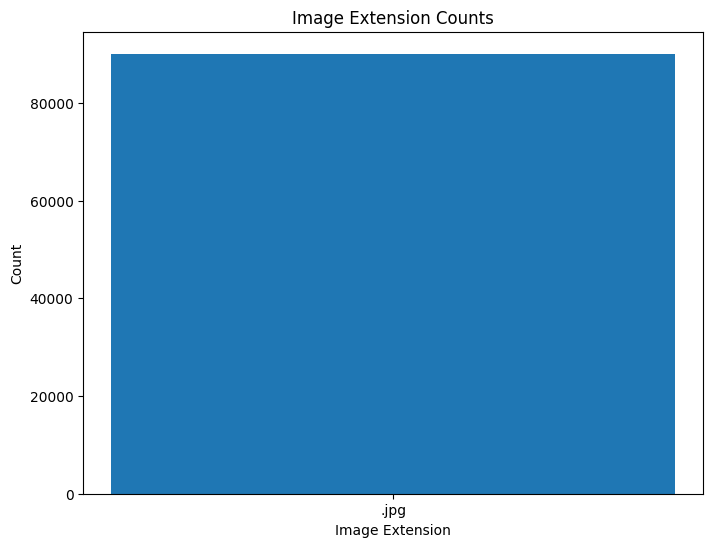

In [14]:
def plot_extension_counts(image_paths_list):
    extension_counts = {}

    for image_paths in image_paths_list:
        for image_path in image_paths:
            extension = os.path.splitext(image_path)[1]
            extension_counts[extension] = extension_counts.get(extension, 0) + 1
    
    extensions = list(extension_counts.keys())
    counts = list(extension_counts.values())
    
    plt.figure(figsize=(8, 6))
    plt.bar(extensions, counts, width = 0.1)
    plt.xlabel('Image Extension')
    plt.ylabel('Count')
    plt.title('Image Extension Counts')
    plt.show()

plot_extension_counts(image_paths_list)

File extension is crucial, as there can be significant differences among the data for each type of them. So handling those extensions are crucial to maintain the integrity of our dataset.

In this project, fortunately, the image extension is .jpg. Hence, we don't need to handle this task, which can save lots of time for running our model.

### Image count in total

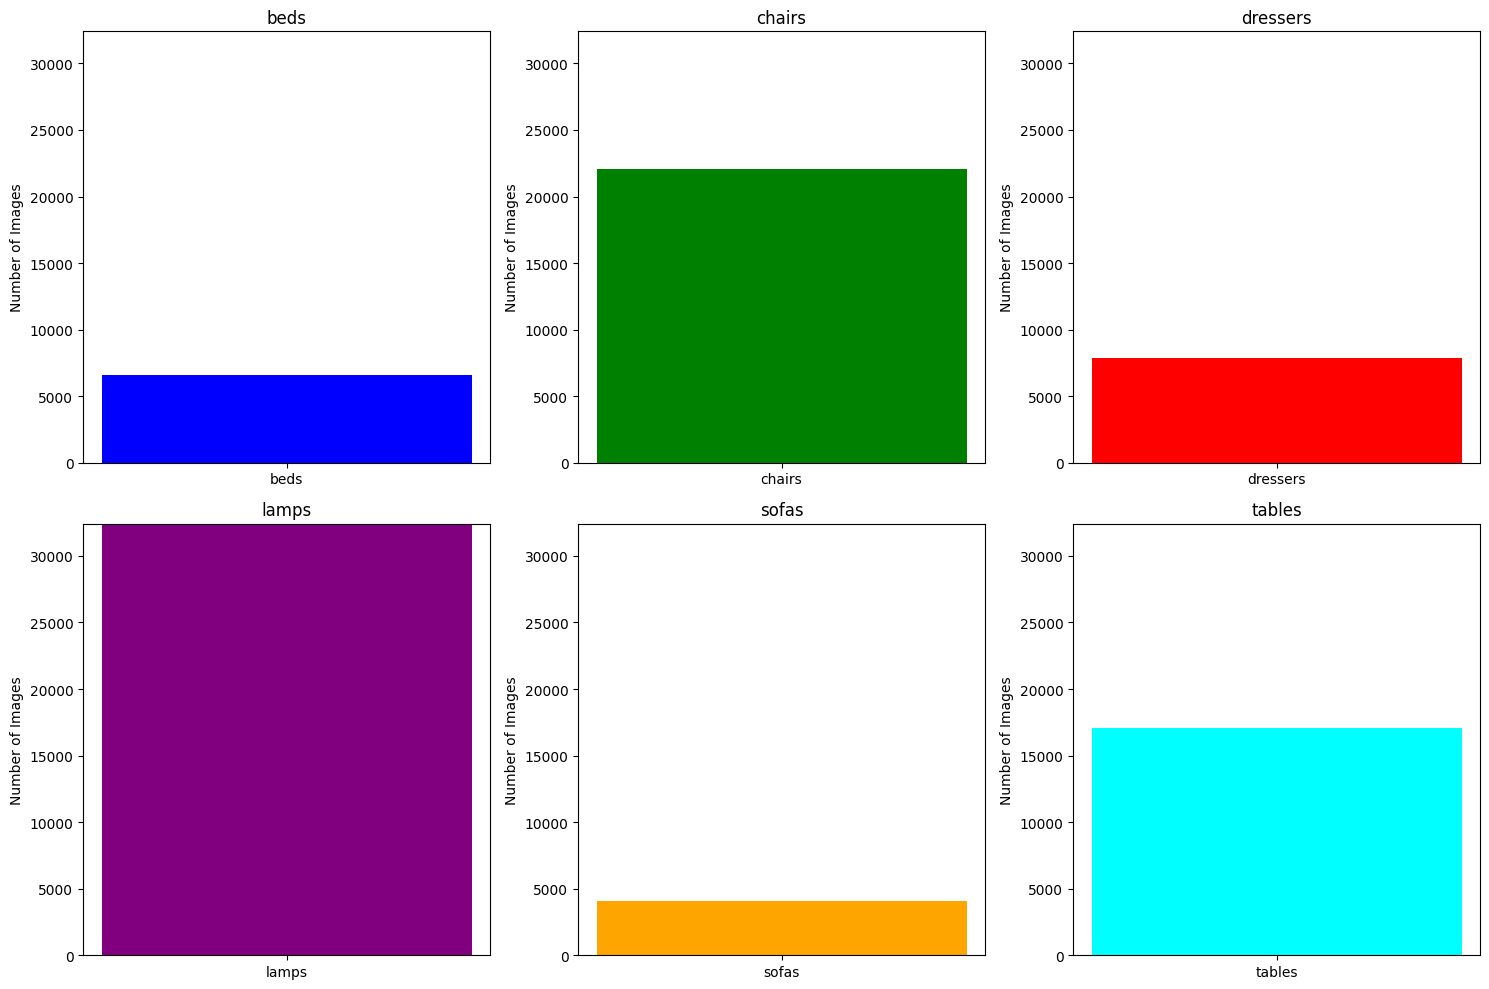

In [15]:
category_counts = {category: len(paths[category]) for category in categories}
colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan']

# Plot bar graphs
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, category in enumerate(categories):
    axes[idx].bar([category], [category_counts[category]], color=colors[idx])
    axes[idx].set_title(category)
    axes[idx].set_ylabel('Number of Images')
    axes[idx].set_ylim(0, max(category_counts.values()) + 10) 

# Adjust layout
plt.tight_layout()
plt.show()

From here, we can notice that the furniture dataset that we have is heavily imbalance, which can affect the result of predictions. Therefore, we might have to consider some of methods to balance the dataset. Some considerations for the tasks are:
- Oversampling: This method will balance the dataset by add more data to columns until they all share the same height. However, doing so will cause the mal-data generation to occur, affecting the result of predictions.
- Undersampling: This method, in contrast with oversampling, down-sample to the lowest. However, data loss is quite considerable, especially for those data with heavy imbalance.
- Data augmentation: Using this method will use the current dataset for oversampling the data. For images, some methods can be done, such as rotating, re-coloring, resolution reduction, ... This allow the integrity of data to be preserved significantly.

### Image size

Similar to image extension, consistent size of images can maintain data's integrity. Even more, images dimension can affect the input dimension of training model, and insistent image size can cause serious bug for the model

We will look through the size's distribution of images in our dataset


Size counts for List beds:
   Size (width, height)  Count
0           (224, 224)   6537
1           (350, 350)     41

Size counts for List chairs:
   Size (width, height)  Count
0           (350, 350)  22053

Size counts for List dressers:
   Size (width, height)  Count
0           (350, 350)   7870

Size counts for List lamps:
   Size (width, height)  Count
0           (350, 350)  32401

Size counts for List sofas:
   Size (width, height)  Count
0           (350, 350)   4080

Size counts for List tables:
   Size (width, height)  Count
0           (350, 350)  17099
1           (500, 446)      1


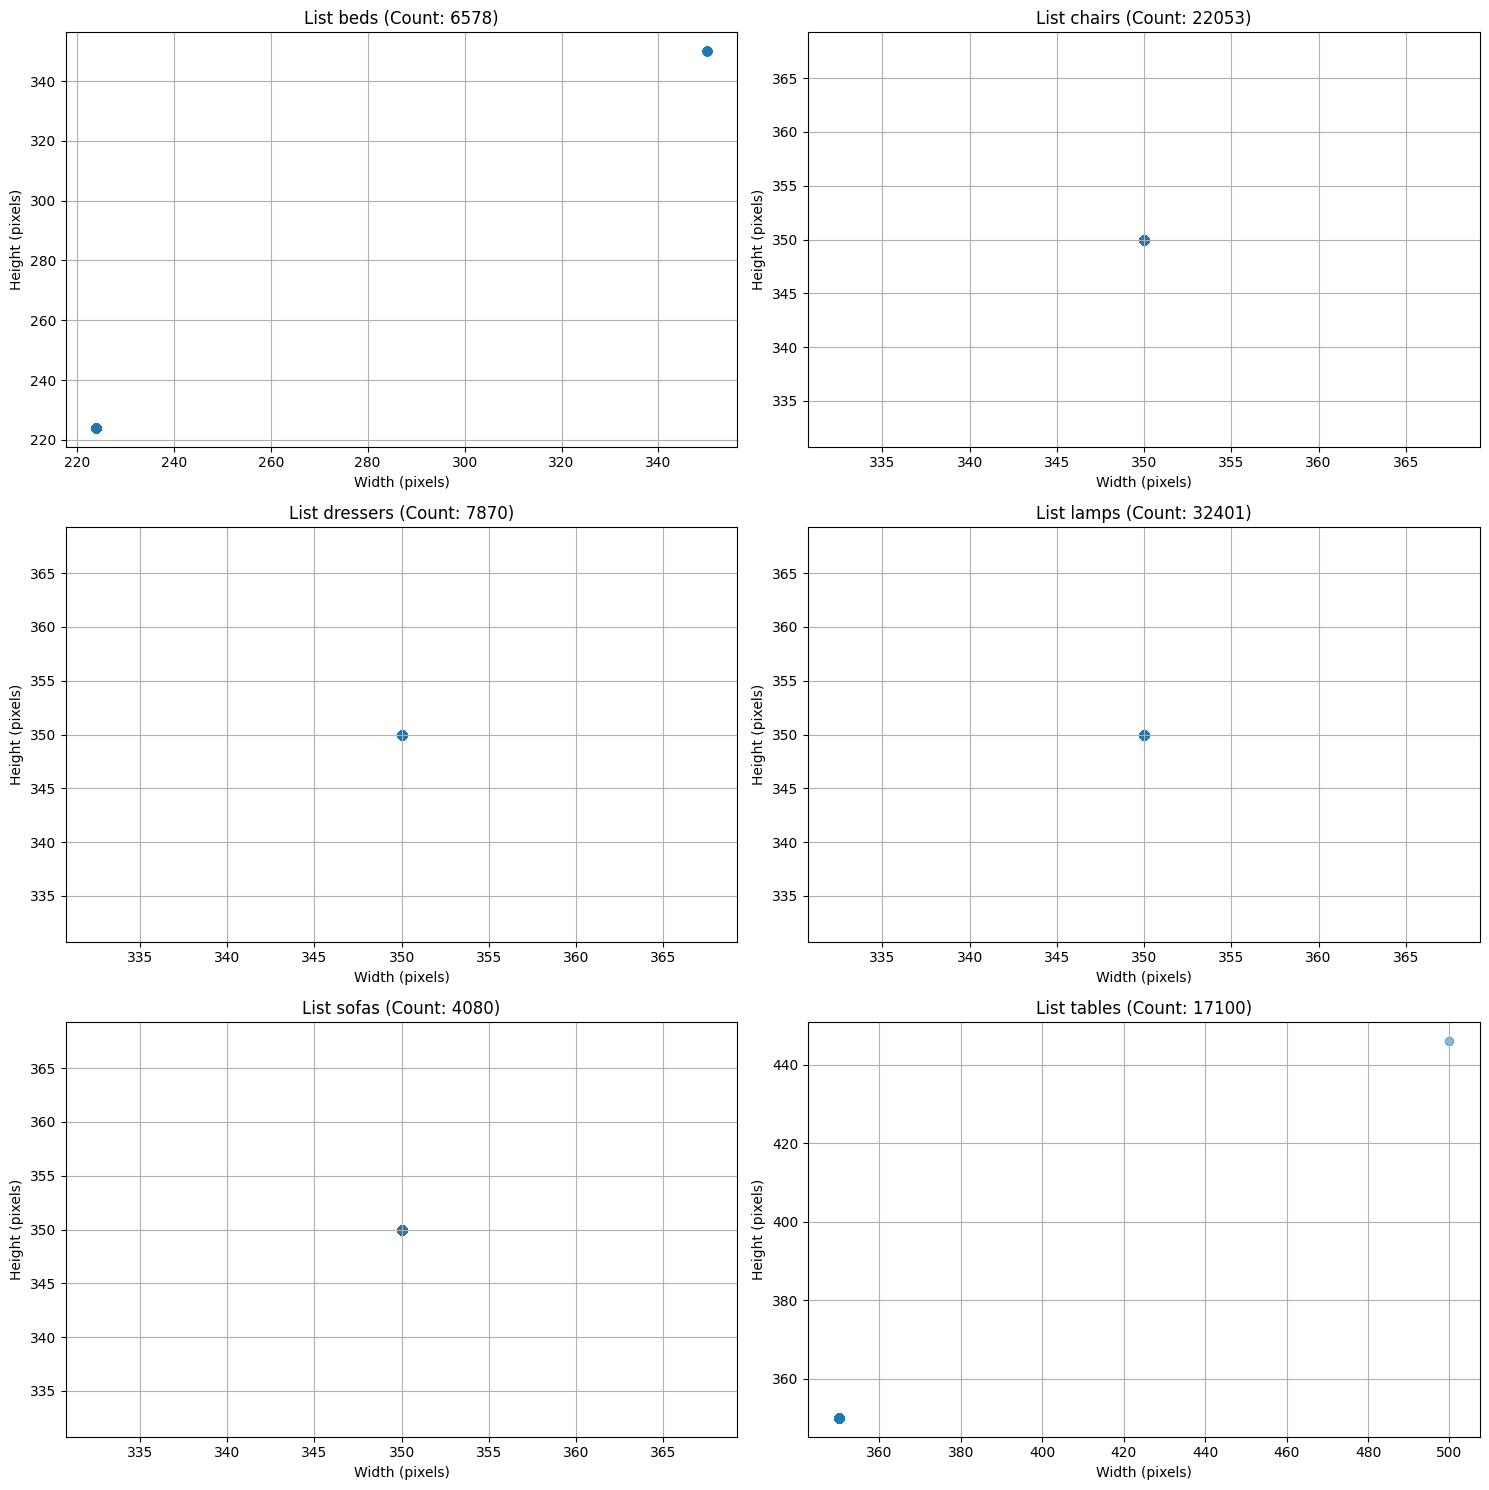

In [16]:


def get_image_size(image_path):
    try:
        with Image.open(image_path) as img:
            width, height = img.size
            return width, height
    except FileNotFoundError:
        print(f"The file at path {image_path} was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")
    return None

def generate_plot_data_and_counts(image_paths):
    sizes = [get_image_size(image_path) for image_path in image_paths if get_image_size(image_path) is not None]
    size_counts = {}
    if sizes:
        widths = [size[0] for size in sizes]
        heights = [size[1] for size in sizes]
        for size in sizes:
            if size in size_counts:
                size_counts[size] += 1
            else:
                size_counts[size] = 1
        return widths, heights, size_counts
    return [], [], {}

def plot_individual_subplots(image_paths_list):
    num_lists = len(image_paths_list)
    num_cols = 2  # Number of columns in the subplot grid
    num_rows = (num_lists + num_cols - 1) // num_cols  # Calculate rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    axes = axes.flatten()  # Flatten the 2D array of axes

    for i, image_paths in enumerate(image_paths_list):
        widths, heights, size_counts = generate_plot_data_and_counts(image_paths)
        if widths and heights:
            axes[i].scatter(widths, heights, alpha=0.5)
            axes[i].set_title(f'List {categories[i]} (Count: {sum(size_counts.values())})')
            axes[i].set_xlabel('Width (pixels)')
            axes[i].set_ylabel('Height (pixels)')
            axes[i].grid(True)

            # Create a DataFrame for the size counts
            size_counts_df = pd.DataFrame(list(size_counts.items()), columns=['Size (width, height)', 'Count'])
            print(f"\nSize counts for List {categories[i]}:\n", size_counts_df)
        else:
            axes[i].set_visible(False)  # Hide subplot if no valid images

    # Hide any remaining empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()


# Plot image sizes from all lists
plot_individual_subplots(image_paths_list)


We can see that, the dominant size of the dataset is 350x350. Even though major image size of 'beds' is 240x240, with some of the outliers from the other categories, we will maintain the 350x350. That is, we will later resize the dataset into the mostly-occured image size.

### Image statistic

Via this section, we can determine the numerical characteristic of each of the image, therefore we can explore more of the model's configuration.

In [17]:
data = {}
for category, items in paths.items():
    imageSizes = process_images(items, category, DATASET_DIR)
    data[category] = {
        "paths": get_category_image_paths(CLEANED_DATASET_DIR, category),
        "imageSizes": imageSizes,
    }


df_dims = {
category: pd.DataFrame([get_image_size(image_path) for image_path in paths[category]], columns=["Width", "Height"])
for category in categories
}

print("Successfully extracted all dimensions!")

Loaded image sizes from cache.
(224, 224) pixels:  6537
(350, 350) pixels:  41
Category 'beds', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Midcentury': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Victorian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Transitional': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Traditional': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Categor

Getting image path for category 'beds':   0%|          | 0/17 [00:00<?, ?it/s]

Loaded image sizes from cache.
(350, 350) pixels:  22053
Category 'chairs', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Midcentury': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Victorian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Transitional': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Traditional': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'cha

Getting image path for category 'chairs':   0%|          | 0/17 [00:00<?, ?it/s]

Loaded image sizes from cache.
(350, 350) pixels:  7870
Category 'dressers', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Midcentury': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Victorian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Transitional': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Traditional': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes from cache

Getting image path for category 'dressers':   0%|          | 0/17 [00:00<?, ?it/s]

Loaded image sizes from cache.
(350, 350) pixels:  32401
Category 'lamps', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Midcentury': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Victorian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Transitional': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Traditional': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Sty

Getting image path for category 'lamps':   0%|          | 0/17 [00:00<?, ?it/s]

Loaded image sizes from cache.
(350, 350) pixels:  4080
Category 'sofas', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Midcentury': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Victorian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Transitional': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Traditional': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Styl

Getting image path for category 'sofas':   0%|          | 0/17 [00:00<?, ?it/s]

Loaded image sizes from cache.
(350, 350) pixels:  17099
(500, 446) pixels:  1
Category 'tables', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Midcentury': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Victorian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Transitional': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Traditional': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes fro

Getting image path for category 'tables':   0%|          | 0/17 [00:00<?, ?it/s]

Successfully extracted all dimensions!


In [18]:
for category in categories:
        print(category.capitalize())
        display(df_dims[category].describe().T)

Beds


,count,mean,std,min,25%,50%,75%,max
Width,6578.0,224.785345,9.917241,224.0,224.0,224.0,224.0,350.0
Height,6578.0,224.785345,9.917241,224.0,224.0,224.0,224.0,350.0


Chairs


,count,mean,std,min,25%,50%,75%,max
Width,22053.0,350.0,0.0,350.0,350.0,350.0,350.0,350.0
Height,22053.0,350.0,0.0,350.0,350.0,350.0,350.0,350.0


Dressers


,count,mean,std,min,25%,50%,75%,max
Width,7870.0,350.0,0.0,350.0,350.0,350.0,350.0,350.0
Height,7870.0,350.0,0.0,350.0,350.0,350.0,350.0,350.0


Lamps


,count,mean,std,min,25%,50%,75%,max
Width,32401.0,350.0,0.0,350.0,350.0,350.0,350.0,350.0
Height,32401.0,350.0,0.0,350.0,350.0,350.0,350.0,350.0


Sofas


,count,mean,std,min,25%,50%,75%,max
Width,4080.0,350.0,0.0,350.0,350.0,350.0,350.0,350.0
Height,4080.0,350.0,0.0,350.0,350.0,350.0,350.0,350.0


Tables


,count,mean,std,min,25%,50%,75%,max
Width,17100.0,350.008772,1.147079,350.0,350.0,350.0,350.0,500.0
Height,17100.0,350.005614,0.734130,350.0,350.0,350.0,350.0,446.0


### Image Example

In this part, we will randomly show some images from our dataset. The images will be shuffled everytime the code snippet is re-run, and will be displayed in the categories

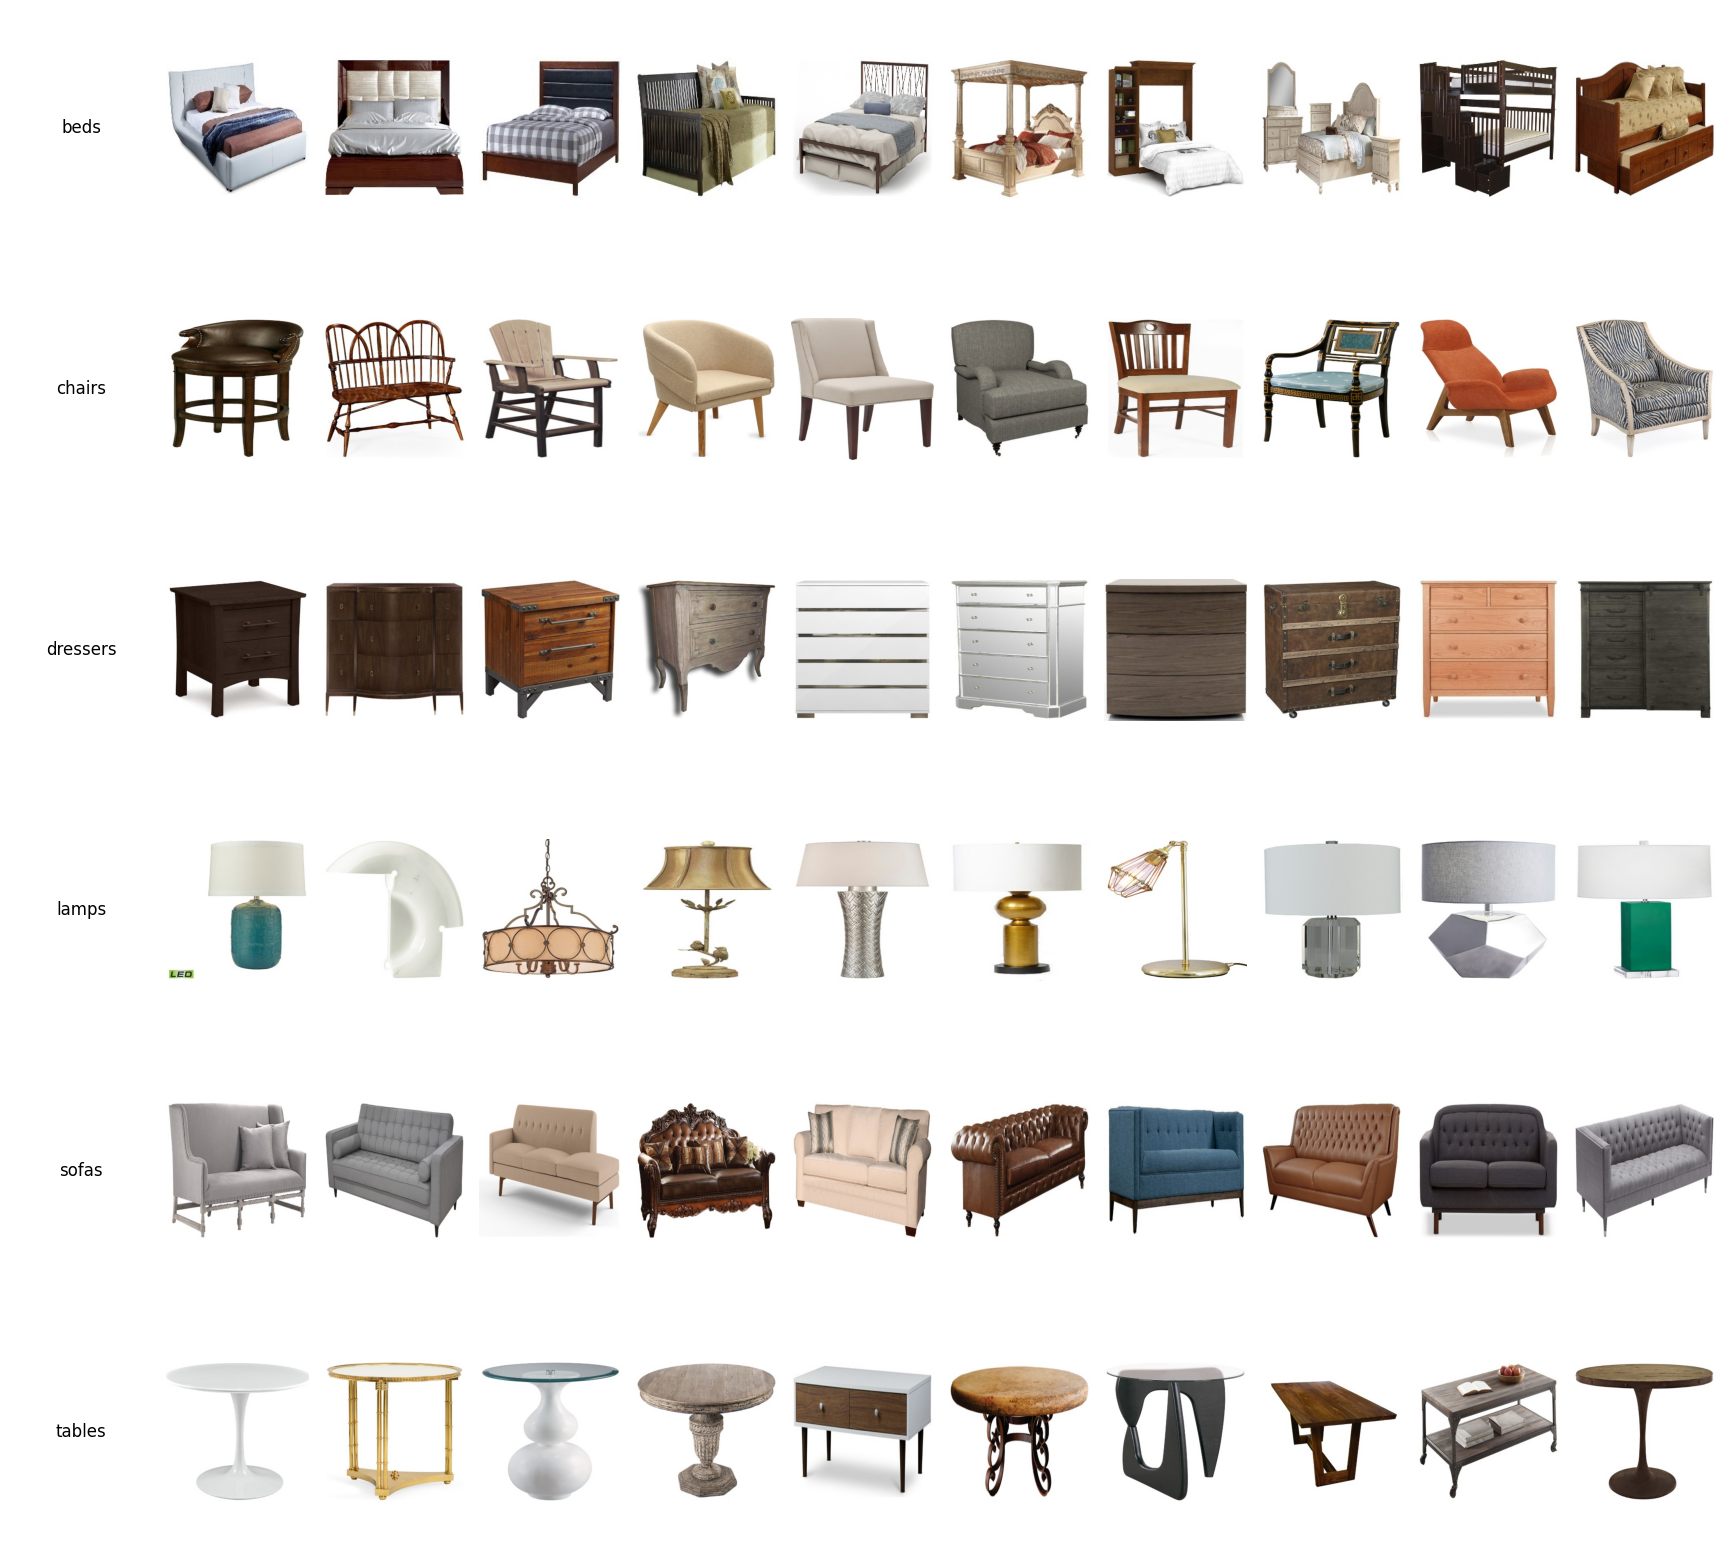

In [19]:
import matplotlib.image as mpimg
import random


num_images = 10
fig, axes = plt.subplots(6, 11, figsize=(22, 20))

for i, category in enumerate(categories):
    image_paths = paths[category]
    random.shuffle(image_paths)
    
    axes[i, 0].text(0.5, 0.5, category, verticalalignment='center', horizontalalignment='center', fontsize=12)
    axes[i, 0].axis('off')

    for j, image_path in enumerate(image_paths[:num_images]):
        img = mpimg.imread(image_path)
        axes[i, j+1].imshow(img)
        axes[i, j+1].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.show()

# Image Duplication

Image duplication is a very influential characteristic in the field of image classification. It's highly dependant, creating unnecessary load for the model to be trained and predict. Handling duplications will provide a better dataset for training, avoiding bias and produce better result 


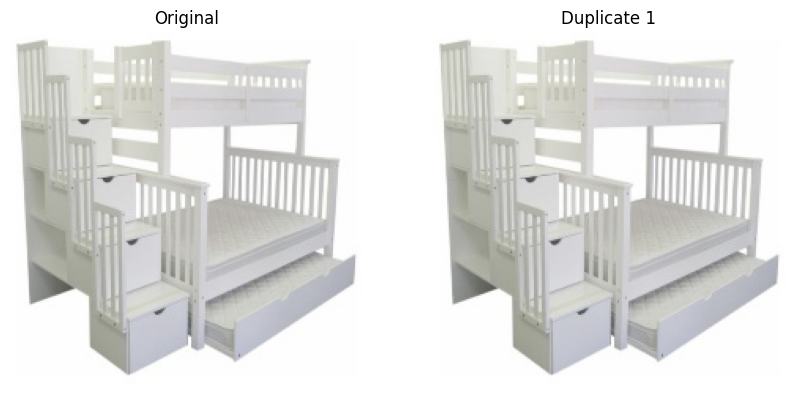

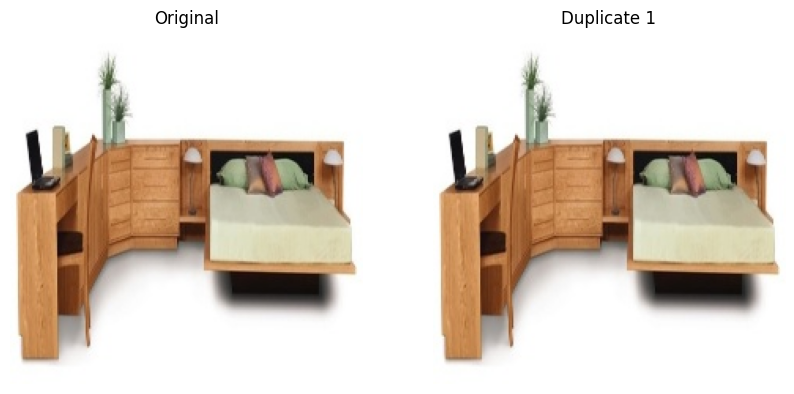

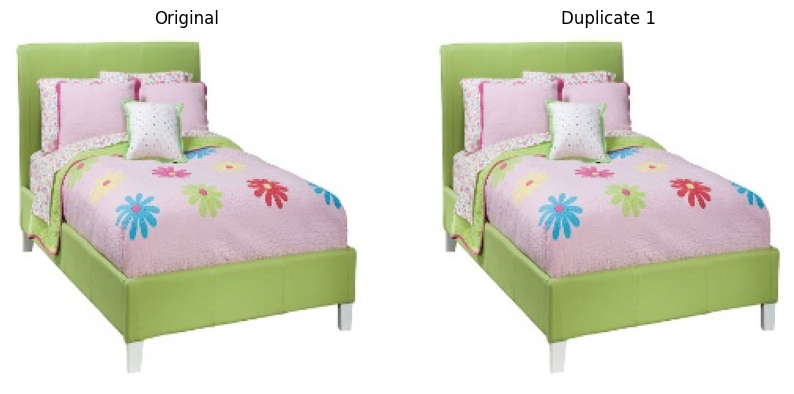

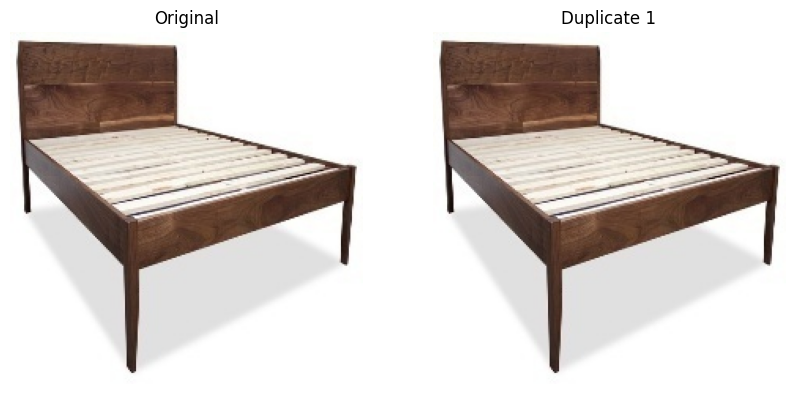

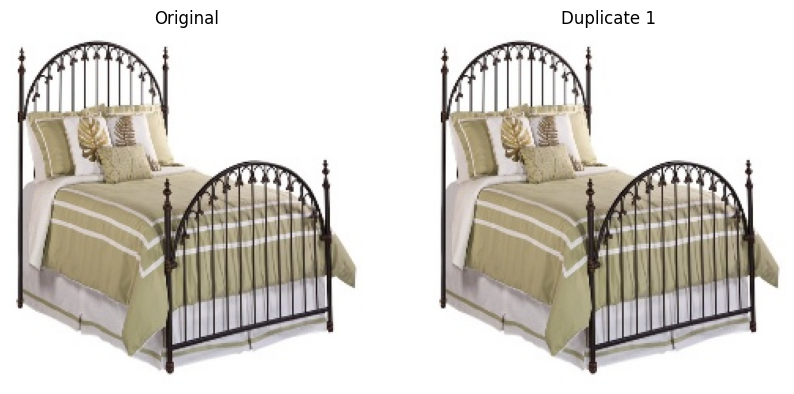

In [20]:
import os
from PIL import Image
import hashlib
import matplotlib.pyplot as plt

def image_hash(image_path):
    """
    Calculate the hash of an image.
    """
    image = Image.open(image_path)
    image_hash = hashlib.md5(image.tobytes()).hexdigest()
    return image_hash

def find_duplicate_images(image_paths):
    """
    Find duplicate images in a list of image paths.
    """
    hash_dict = {}
    duplicate_images_dict = {}

    for image_path in image_paths:
        image_hash_value = image_hash(image_path)
        if image_hash_value not in hash_dict:
            hash_dict[image_hash_value] = image_path
        else:
            original_path = hash_dict[image_hash_value]
            if original_path not in duplicate_images_dict:
                duplicate_images_dict[original_path] = [image_path]
            else:
                duplicate_images_dict[original_path].append(image_path)

    return duplicate_images_dict

def plot_images(original_path, duplicate_paths):
    """
    Plot the original image and its duplicates.
    """
    num_duplicates = len(duplicate_paths) + 1
    fig, axes = plt.subplots(1, num_duplicates, figsize=(10, 5))

    # Plot original image
    original_image = Image.open(original_path)
    axes[0].imshow(original_image)
    axes[0].set_title("Original")
    axes[0].axis('off')

    # Plot duplicate images
    for i, duplicate_path in enumerate(duplicate_paths, start=1):
        duplicate_image = Image.open(duplicate_path)
        axes[i].imshow(duplicate_image)
        axes[i].set_title(f"Duplicate {i}")
        axes[i].axis('off')

    plt.show()

# Example usage:
image_paths = paths["beds"]

duplicate_images_dict = find_duplicate_images(image_paths)

# Plot the original image and its duplicates for at most 5 key-value pairs
count = 0
for original_path, duplicate_paths in duplicate_images_dict.items():
    if count >= 5:
        break
    plot_images(original_path, duplicate_paths)
    count += 1


From here, we will take 'beds' path to visualize duplication. We will display 2 images per duplication (as each of the origin can have multiple duplciations) The duplication can have some of the following characteristis:
- Completely similar, from size to color
- Slightly different in color
- Slightly different from size

Seeing the gray scale below, we can understand more about the duplicate-removing process

### Gray-scale pattern on duplicated images

We will now turn the image from RGB to gray scale, and then downscale the size to 9x9. By doing this, we can see the image pattern that determine whether it is duplicated or not

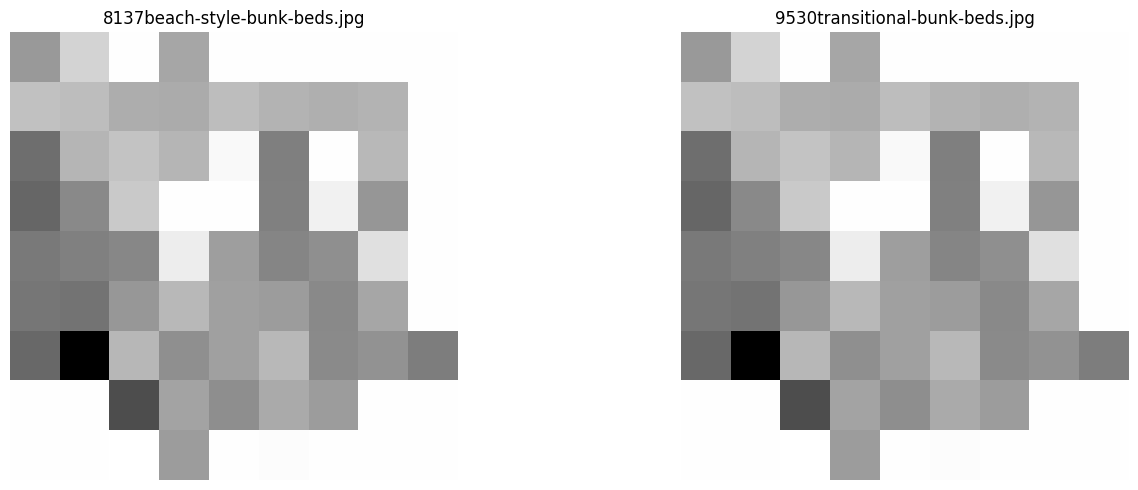

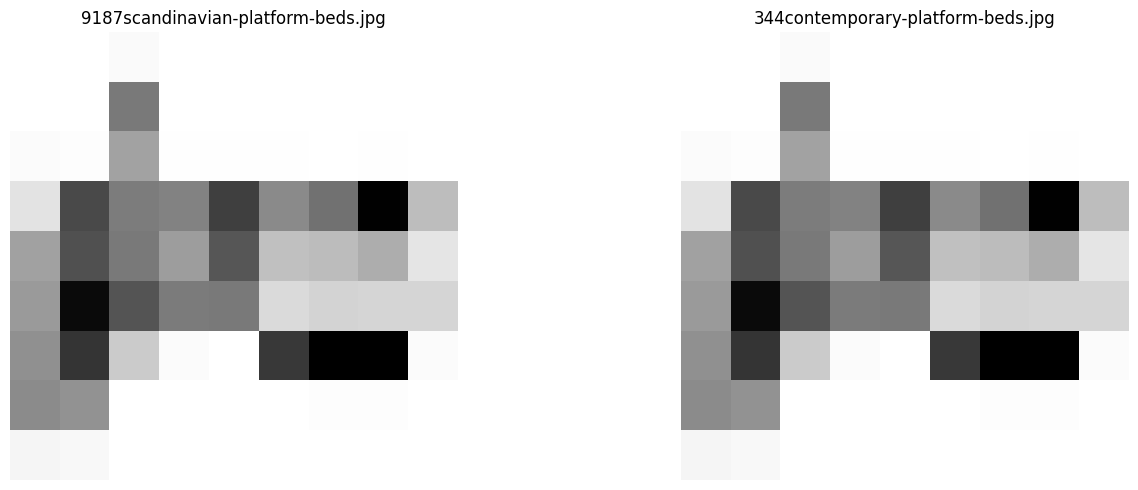

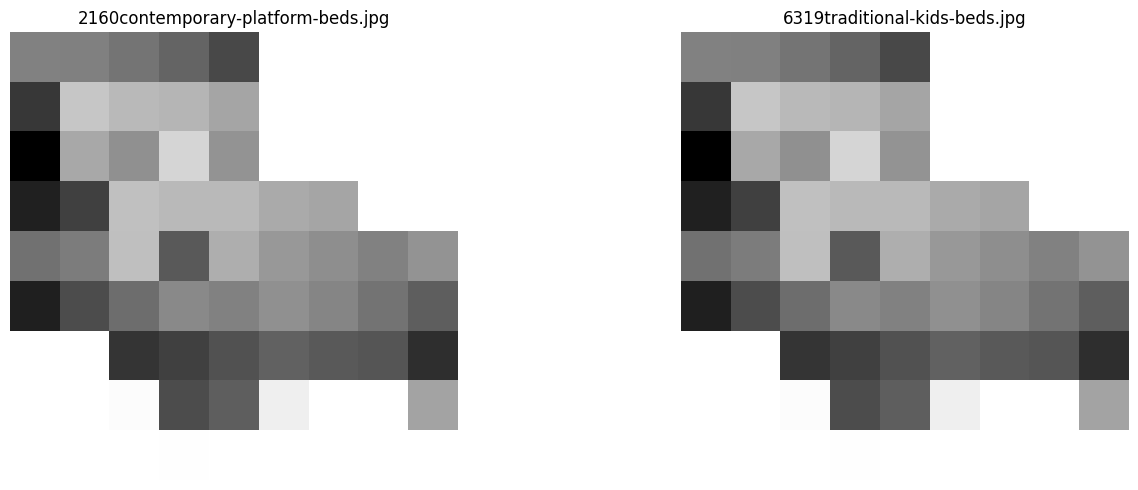

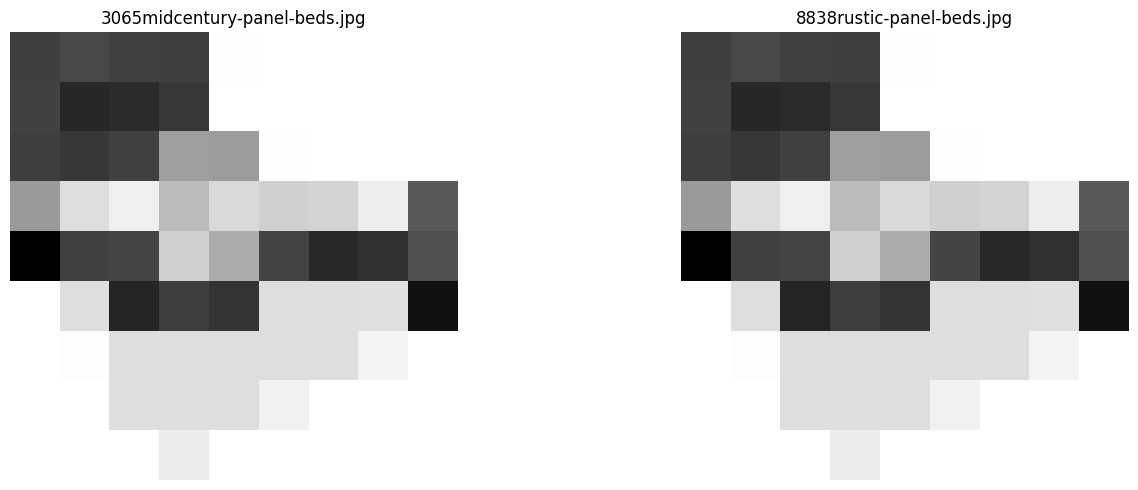

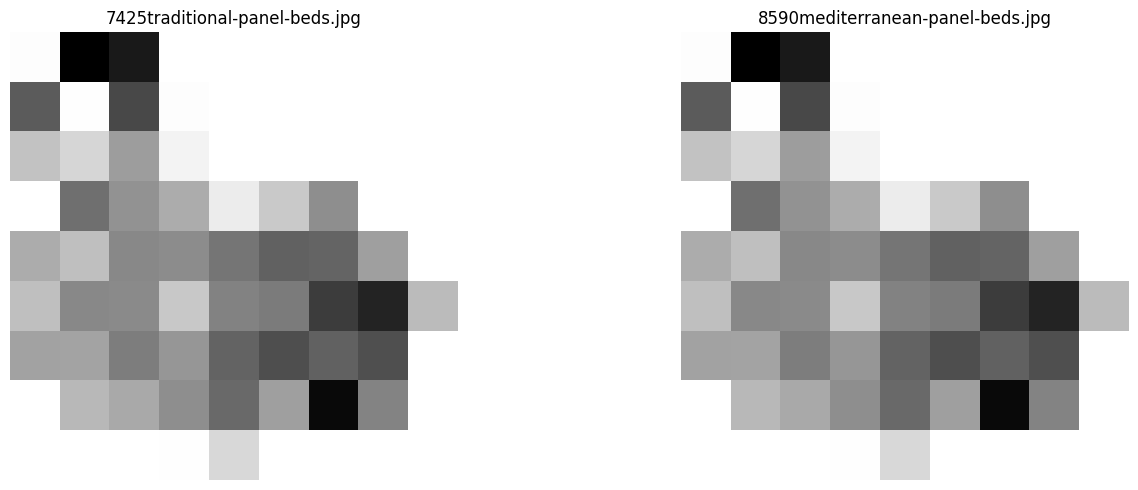

In [21]:
import cv2
from matplotlib import pyplot as plt

def load_convert_and_downscale_images(image_path, size=(9, 9)):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Failed to read image at path {image_path}")
        return None
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    downscaled_image = cv2.resize(gray_image, size)
    return downscaled_image

def visualize_images(images):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i, (image_path, image) in enumerate(images):
        if image is not None:
            axes[i].imshow(image, cmap='gray')
            axes[i].axis('off')
            axes[i].set_title(image_path.split('/')[-1])  # Show file name
        else:
            axes[i].axis('off')  # If image is None, just turn off the axis

    plt.tight_layout()
    plt.show()

# Example usage:
image_paths = paths["beds"]

duplicate_images_dict = find_duplicate_images(image_paths)

# Process and visualize the first 5 key-value pairs
count = 0
for original_path, duplicate_paths in duplicate_images_dict.items():
    if count >= 5:
        break
    processed_original_image = load_convert_and_downscale_images(original_path)
    
    processed_duplicate_images = [load_convert_and_downscale_images(image_path) for image_path in duplicate_paths]
    
    images_to_visualize = [(original_path, processed_original_image)] + [(image_path, image) for image_path, image in zip(duplicate_paths, processed_duplicate_images)]
    
    visualize_images(images_to_visualize)
    
    count += 1


Investigating into these images, we can retrieve that gray scale pattern of the images are familiar. Since gray scale only has 2 bits, the slight differences in size and color doesn't change much of the pixel, which we can use the determine duplicated images

### Check duplicate and resize model

In [22]:
data = {}
for category, items in paths.items():
    imageSizes = process_images(items, category, DATASET_DIR)
    data[category] = {
        "paths": get_category_image_paths(CLEANED_DATASET_DIR, category),
        "imageSizes": imageSizes,
    }

paths = {
    category: get_category_image_paths(CLEANED_DATASET_DIR, category)
    for category in categories
}

print("Successfully extracted all paths and image sizes!")

Loaded image sizes from cache.
(224, 224) pixels:  6537
(350, 350) pixels:  41
Category 'beds', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Midcentury': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Victorian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Transitional': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Traditional': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Categor

Getting image path for category 'beds':   0%|          | 0/17 [00:00<?, ?it/s]

Loaded image sizes from cache.
(350, 350) pixels:  22053
Category 'chairs', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Midcentury': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Victorian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Transitional': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Traditional': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'cha

Getting image path for category 'chairs':   0%|          | 0/17 [00:00<?, ?it/s]

Loaded image sizes from cache.
(350, 350) pixels:  7870
Category 'dressers', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Midcentury': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Victorian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Transitional': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Traditional': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes from cache

Getting image path for category 'dressers':   0%|          | 0/17 [00:00<?, ?it/s]

Loaded image sizes from cache.
(350, 350) pixels:  32401
Category 'lamps', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Midcentury': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Victorian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Transitional': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Traditional': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Sty

Getting image path for category 'lamps':   0%|          | 0/17 [00:00<?, ?it/s]

Loaded image sizes from cache.
(350, 350) pixels:  4080
Category 'sofas', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Midcentury': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Victorian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Transitional': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Traditional': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Styl

Getting image path for category 'sofas':   0%|          | 0/17 [00:00<?, ?it/s]

Loaded image sizes from cache.
(350, 350) pixels:  17099
(500, 446) pixels:  1
Category 'tables', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Midcentury': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Victorian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Transitional': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Traditional': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes fro

Getting image path for category 'tables':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'beds':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'chairs':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'dressers':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'lamps':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'sofas':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'tables':   0%|          | 0/17 [00:00<?, ?it/s]

Successfully extracted all paths and image sizes!


In [23]:
total = 0

# Print the amount for each category
for category in categories:
    amount = len(data[category]["paths"])
    print(f"Amount of {category}: {amount}")
    total += amount

# Print the total
print("Total:", total)

Amount of beds: 6542
Amount of chairs: 20069
Amount of dressers: 6650
Amount of lamps: 22981
Amount of sofas: 3384
Amount of tables: 16071
Total: 75697


Text(0, 0.5, 'Amount')

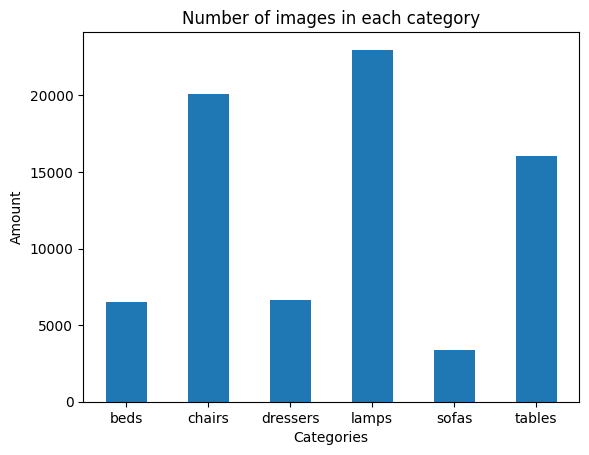

In [24]:
plt.bar(
    categories, [len(data[category]["paths"]) for category in categories], width=0.5
)
plt.title("Number of images in each category")
plt.xlabel("Categories")
plt.ylabel("Amount")

## Conclusion

- The dataset contains 6 categories of items with 90082 items total
- The dataset contains all file with JPG type
- The dataset contains image mainly in two dimensions: 224x224 and 350x350. However there are one anomaly dimensions in the table category which is: 500x446
- After detecting duplication, we have 75697 images left


For data preprocessing and model training/evaluation, we have integrated into date pipeline file - pipeline.ipynb. Please have a walkthrough in there for detailed data processing